In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, sklearn
from os import listdir
from os.path import join
from fnmatch import filter

sys.path.append("../../profiling/")
import metrics
import quality
import profiling.profiling as profiling

In [2]:
# Load correlation matrices for each fixed seed experiment
matrices = {m.split('_')[1]: profiling.load_similarity_matrix(join('features', m)) for m in filter(listdir('features'), 'seed_*_matrix.csv')}

# Load baseline matrix
matrices['paper'] = profiling.load_similarity_matrix("features/BBBC037_matrix.csv")

In [ ]:
def moa_matching(Y):
    moa_matches = []
    Y["Ref_moa"] = Y["Metadata_moa.x"].str.replace('|', '___', regex=True)
    for _, r in Y.iterrows():
        moas = r["Metadata_moa.x"].split("|")
        candidates = []
        for m in moas:
            reg = r'(^|___){}($|___)'.format(m)
            candidates.append(Y["Ref_moa"].str.contains(reg))
        matches = candidates[0]
        for c in candidates:
            matches = matches | c
        moa_matches.append(matches)
    
    return np.asarray(moa_matches)

moa_matches = {ch: moa_matching(Y) for ch, (_, Y) in matrices.items()}

# Enrichment analysis

One-sided Fisher's exact test

Threshold: 99th percentile

2x2 contingency table

|             | Positive matches | Negative matches |
| ----------- | ---------------- | ---------------- |
| At thr      | 1                | 9                |
| Below thr   | 31               | 953              |

Ods ratio: $\frac{1/9}{31/953} = 3.42$

*It estimates the likelihood of observing the treatment with the same MoA or pathway in the top connections.*





In [4]:
def enrichment_analysis(X, Y, moa_matches):
    results = {}
    SIM = np.asarray(X[Y.Var1])
    is_query = moa_matches.sum(axis=0) > 1

    for i in range(SIM.shape[0]):
        if is_query[i]:
            idx = [x for x in range(SIM.shape[1]) if x != i]
            results[i] = quality.enrichment_analysis(SIM[i,idx], moa_matches[i,idx], 99.)
            if results[i]["ods_ratio"] is np.nan:
                print(results[i]["V"], i)
    
    folds = [results[x]["ods_ratio"] for x in results]

    return np.mean(folds)

avg_folds = {ch: enrichment_analysis(X, Y, moa_matches[ch]) for ch, (X,Y) in matrices.items()}
avg_folds = dict(sorted(avg_folds.items(), key=lambda x: x[1], reverse=True))

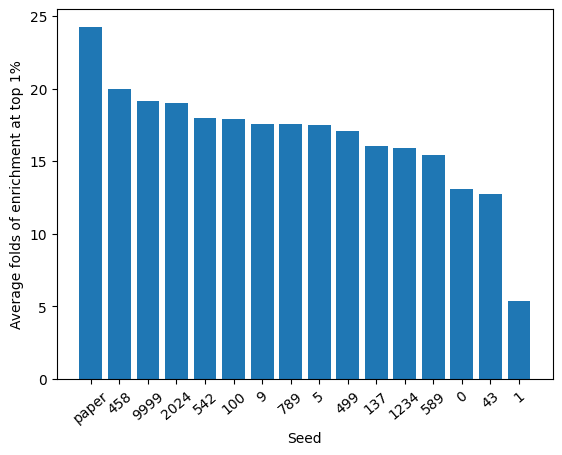

In [5]:
plt.bar(avg_folds.keys(), avg_folds.values())
plt.xticks(rotation=40)
plt.xlabel('Seed')
plt.ylabel('Average folds of enrichment at top 1%')
plt.show()

# Average precision analysis

Za vsak broad_sample-broad_sample par: Vzami *k* najbolj podobnih broad_sample-ov po cosinusu (iz `similarity_matrix`) in vrni povprečje števila ujemanj v MoA (`moa_matches`).

In [6]:
def precision_at_k(X, Y, moa_matches, rank_pos=None):
    results = {}
    sim_matrix = np.asarray(X[Y.Var1])
    is_query = moa_matches.sum(axis=0) > 1
    
    for i in range(sim_matrix.shape[0]):
        if is_query[i]:
            idx = [x for x in range(sim_matrix.shape[1]) if x != i]
            ranking = np.argsort(-sim_matrix[i,idx])
            pk = metrics.precision_at_k(moa_matches[i, ranking[1:]], rank_pos)
            results[i] = {"precision_at_k":pk,"pk":rank_pos}
    return results

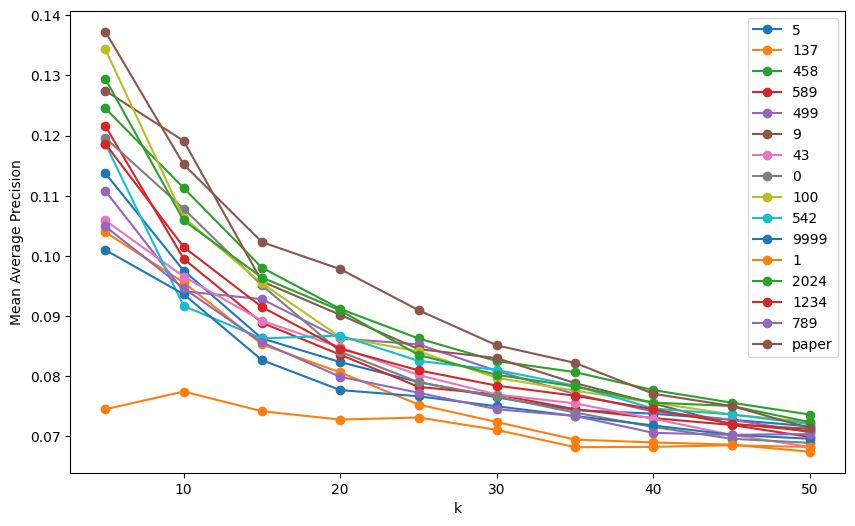

In [7]:
average_precisions = dict()
positions = [x for x in range(5,55,5)]

for ch, (X, Y) in matrices.items():
    average_precision_at_k = []
    for pos in positions:
        prec_k = precision_at_k(X, Y, moa_matches[ch], pos)
        average_precision_at_k.append(np.mean([prec_k[q]["precision_at_k"] for q in prec_k]))
    average_precisions[ch] = average_precision_at_k

plt.figure(figsize=(10,6))
for ch, avg_prec in average_precisions.items():
    plt.plot(positions, avg_prec, marker='o', label=ch)
plt.xlabel('k')
plt.ylabel('Mean Average Precision')
plt.legend()
plt.show()

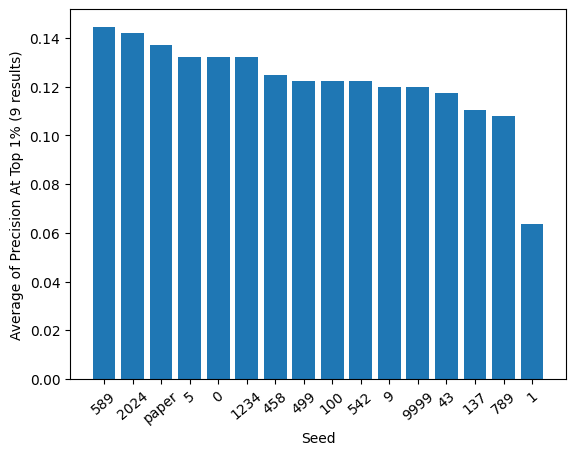

In [8]:
top_1 = dict()
for ch, (X, Y) in matrices.items():
    top_1percent = max(int(X.shape[0] * 0.01), 1)
    top_prec = precision_at_k(X, Y, moa_matches[ch], top_1percent)
    avg_top_prec = np.mean([top_prec[q]["precision_at_k"] for q in top_prec])
    top_1[ch] = avg_top_prec

top_1 = dict(sorted(top_1.items(), key=lambda x: x[1], reverse=True))

plt.bar(top_1.keys(), top_1.values())
plt.xticks(rotation=40)
plt.xlabel('Seed')
plt.ylabel('Average of Precision At Top 1% (9 results)')
plt.show()

# Recall analysis

In [9]:
def recall_at(X, Y, moa_matches, rank_pos=None):
    results = {}
    sim_matrix = np.asarray(X[Y.Var1])
    is_query = moa_matches.sum(axis=0) > 1
    for i in range(sim_matrix.shape[0]):
        if is_query[i]:
            ranking = np.argsort(-sim_matrix[i,:])
            rc = np.sum(moa_matches[i, ranking[1:rank_pos]]) / np.sum(moa_matches[i,:])
            results[i] = {"recall_at_k":rc, "rk":rank_pos}
    return results

In [10]:
recalls = dict()
for ch, (X, Y) in matrices.items():
    recall = []
    for pos in positions:
        recall_k = recall_at(X, Y, moa_matches[ch], pos)
        recall.append(np.mean([recall_k[x]["recall_at_k"] for x in recall_k]))
    
    recalls[ch] = recall

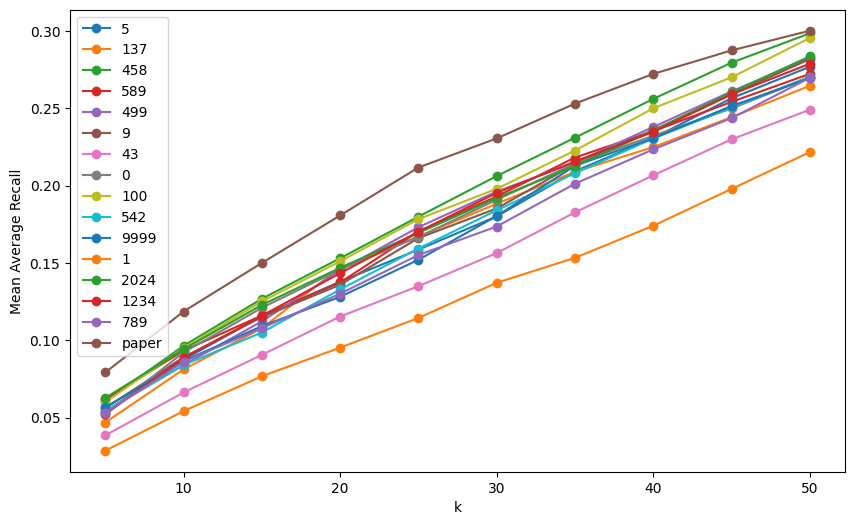

In [11]:
plt.figure(figsize=(10,6))
for ch, recall in recalls.items():
    plt.plot(positions, recall, marker='o', label=ch)
plt.xlabel('k')
plt.ylabel('Mean Average Recall')
plt.legend()
plt.show()

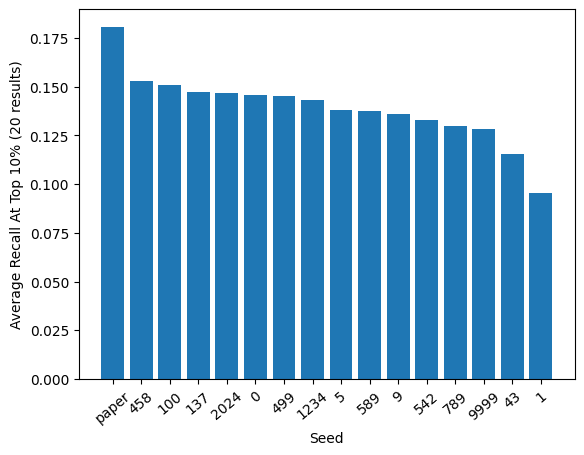

In [12]:
avg_recalls_at_top = dict()
for ch, (X, Y) in matrices.items():
    recall_top_10 = recall_at(X, Y, moa_matches[ch], top_1percent * 10)
    avg_recall_at_top = np.mean([recall_top_10[x]["recall_at_k"] for x in recall_top_10])
    avg_recalls_at_top[ch] = avg_recall_at_top

avg_recalls_at_top = dict(sorted(avg_recalls_at_top.items(), key=lambda x: x[1], reverse=True))

plt.bar(avg_recalls_at_top.keys(), avg_recalls_at_top.values())
plt.xticks(rotation=40)
plt.xlabel('Seed')
plt.ylabel(f'Average Recall At Top 10% ({top_1percent * 10} results)')
plt.show()

# Interpolated Recall-Precision Curve

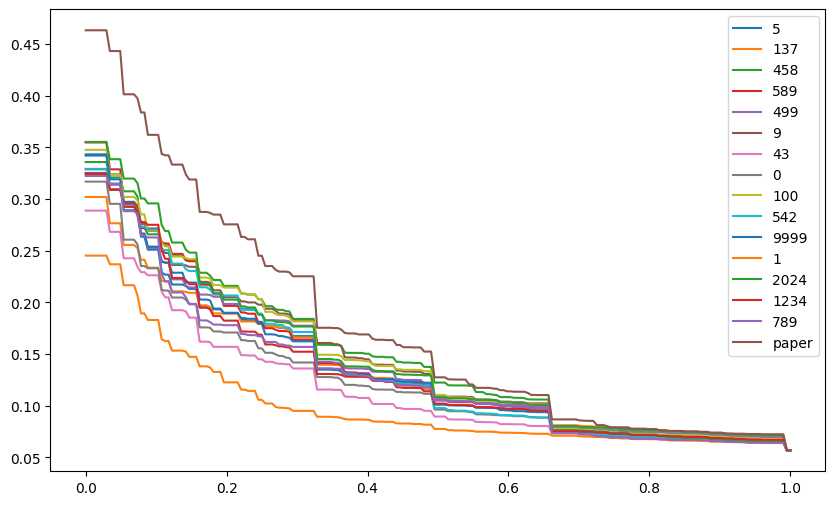

Mean Average Precision (MAP): 	 0.1781149433829878
Area Under the PR curve: 	 0.17771289418098196


In [13]:
interpolated_pr_re_curve = dict()

plt.figure(figsize=(10,6))
for ch, (X, Y) in matrices.items():
    recall_axis, average_precision = metrics.interpolated_precision_recall_curve(moa_matches[ch], np.asarray(X[Y.Var1]))
    plt.plot(recall_axis, average_precision, label=ch)
    interpolated_pr_re_curve[ch] = [np.mean(average_precision), sklearn.metrics.auc(recall_axis, average_precision)]

plt.legend()
plt.show()

print("Mean Average Precision (MAP): \t", np.mean(average_precision))
print("Area Under the PR curve: \t", sklearn.metrics.auc(recall_axis, average_precision))

In [14]:
df = {'Var1': matrices['paper'][1]['Var1']}
for m, (X, Y) in matrices.items():
    df[m] = Y['Var2']

df = pd.DataFrame(df)
df['Matching paper'] = df.apply(lambda r: sum([r['paper'] == x for x in r.drop(['Var1', 'paper']).values]), axis=1)
df['Unique'] = df.apply(lambda r: len(set(r.drop(['Var1', 'Matching paper', 'paper']).values)), axis=1)

df

,Var1,5,137,458,589,499,9,43,0,100,542,9999,1,2024,1234,789,paper,Matching paper,Unique
0,BRDN0000464846,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,BRDN0000464847,15,1
1,BRDN0000464847,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,BRDN0000464846,15,1
2,BRDN0000464848,ccsbBroad304_01144,ccsbBroad304_00490,BRDN0000464849,ccsbBroad304_14574,BRDN0000464849,BRDN0000464847,BRDN0000464850,BRDN0000464849,BRDN0000464849,ccsbBroad304_14574,BRDN0000464924,ccsbBroad304_14572,ccsbBroad304_14574,BRDN0000464849,BRDN0000464900,BRDN0000464849,5,9
3,BRDN0000464849,ccsbBroad304_06055,ccsbBroad304_07217,BRDN0000464850,BRDN0000464850,BRDN0000464848,ccsbBroad304_00156,BRDN0000464848,ccsbBroad304_06055,ccsbBroad304_14574,ccsbBroad304_00565,ccsbBroad304_14574,ccsbBroad304_14596,BRDN0000464913,ccsbBroad304_01144,ccsbBroad304_08230,BRDN0000464848,2,11
4,BRDN0000464850,BRDN0000464953,ccsbBroad304_01029,ccsbBroad304_14825,ccsbBroad304_06837,ccsbBroad304_06837,ccsbBroad304_01029,BRDN0000464947,ccsbBroad304_14699,ccsbBroad304_06837,BRDN0000464851,BRDN0000464953,ccsbBroad304_00277,BRDN0000464851,ccsbBroad304_06837,ccsbBroad304_14699,BRDN0000464851,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,ccsbBroad304_14850,ccsbBroad304_07012,ccsbBroad304_06837,BRDN0000464908,BRDN0000464908,ccsbBroad304_02857,ccsbBroad304_02857,BRDN0000464869,BRDN0000464943,ccsbBroad304_07012,ccsbBroad304_06837,ccsbBroad304_07012,ccsbBroad304_00498,ccsbBroad304_06837,ccsbBroad304_07012,ccsbBroad304_00100,ccsbBroad304_07012,4,8
201,ccsbBroad304_14853,ccsbBroad304_01613,BRDN0000464865,ccsbBroad304_02889,ccsbBroad304_02889,ccsbBroad304_02889,ccsbBroad304_02889,BRDN0000464916,ccsbBroad304_02889,ccsbBroad304_01613,ccsbBroad304_01613,ccsbBroad304_01613,BRDN0000464865,ccsbBroad304_02889,ccsbBroad304_02889,ccsbBroad304_02889,ccsbBroad304_01613,4,4
202,ccsbBroad304_14856,ccsbBroad304_06150,BRDN0000464898,ccsbBroad304_14699,ccsbBroad304_09091,ccsbBroad304_01029,ccsbBroad304_06150,BRDN0000464898,BRDN0000464927,BRDN0000464898,BRDN0000464937,BRDN0000464927,ccsbBroad304_14528,BRDN0000464898,ccsbBroad304_01029,BRDN0000464937,BRDN0000464898,4,8
203,ccsbBroad304_15022,ccsbBroad304_14853,ccsbBroad304_14853,ccsbBroad304_06771,BRDN0000464877,BRDN0000464877,ccsbBroad304_02218,ccsbBroad304_06846,ccsbBroad304_14528,ccsbBroad304_06771,BRDN0000464858,ccsbBroad304_06150,BRDN0000464904,ccsbBroad304_06150,ccsbBroad304_00282,ccsbBroad304_06771,ccsbBroad304_02831,0,10


In [15]:
df = {'Reference MoA': matrices['paper'][1]['Ref_moa']}
for m, (X, Y) in matrices.items():
    df[m] = Y['Metadata_moa.y']

df = pd.DataFrame(df)
df['Matching paper'] = df.apply(lambda r: sum([r['paper'] == x for x in r.drop(['Reference MoA', 'paper']).values]), axis=1)
df['Unique'] = df.apply(lambda r: len(set(r.drop(['Reference MoA', 'Matching paper', 'paper']).values)), axis=1)

df

,Reference MoA,5,137,458,589,499,9,43,0,100,542,9999,1,2024,1234,789,paper,Matching paper,Unique
0,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,15,1
1,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,Transcription Factors,15,1
2,Chromatin Modifiers,Cytoskeletal Re-org,TOR,RTK,Cell Cycle,RTK,Transcription Factors,RTK,RTK,RTK,Cell Cycle,ER Stress/UPR,Cell Cycle,Cell Cycle,RTK,ER Stress/UPR,RTK,6,6
3,RTK,WNT,WNT,RTK,RTK,Chromatin Modifiers,Apoptosis,Chromatin Modifiers,WNT,Cell Cycle,Hypoxia,Cell Cycle,MAPK,ER Stress/UPR,Cytoskeletal Re-org,NFkB,Chromatin Modifiers,2,10
4,RTK,MAPK,MAPK,MAPK,MAPK,MAPK,MAPK,Hypoxia,MAPK,MAPK,RTK,MAPK,Cell Cycle,RTK,MAPK,MAPK,RTK,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Hippo,Hippo,MAPK,DNA Damage,DNA Damage,BMP,BMP,Hedgehog,NFkB,Hippo,MAPK,Hippo,MAPK,MAPK,Hippo,Cytoskeletal Re-org,Hippo,4,7
201,TOR,TOR,NOTCH,Hippo,Hippo,Hippo,Hippo,Autophagy,Hippo,TOR,TOR,TOR,NOTCH,Hippo,Hippo,Hippo,TOR,4,4
202,MAPK,Translation,MAPK,MAPK,Mitochondria Oxidative Phosphorylation,MAPK,Translation,MAPK,WNT,MAPK,PI3K/AKT,WNT,BMP,MAPK,MAPK,PI3K/AKT,MAPK,7,6
203,TOR,TOR,TOR,PKA,ER Stress/UPR,ER Stress/UPR,NFkB,Cell Cycle,BMP,PKA,PKA,Translation,Translation,Translation,Cell Cycle,PKA,TOR,2,7
